In [1]:
#all imports here, please

import numpy as np

import torch
import torchaudio
import torchaudio_filters as tf

import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

Общая инфомрация о лекции

In [309]:
waveform_full, sr = torchaudio.load('lecture1.wav')
channels, n_samples = waveform_full.shape
duration_sec = n_samples / sr

print(f"Каналов: {channels}\nSample rate: {sr}\nДлительность: {duration_sec/60:.2f} min")


Каналов: 2
Sample rate: 48000
Длительность: 81.35 min


In [310]:
waveform_solo = torch.mean(waveform_full,0,keepdim=True)

In [315]:
max_val = waveform_solo.max().item()
min_val = waveform_solo.min().item()
mean_val = waveform_solo.mean().item()
std_val = waveform_solo.std().item()
zero_ratio = (waveform_solo == 0.0).sum().item() / waveform_solo.numel()

print(f"Макс амплитуда: {max_val:.10f}")
print(f"Мин амплитуда: {min_val:.10f}")
print(f"Средняя амплитуда: {mean_val:.10f}")
print(f"STD амплитуды: {std_val:.10f}")
print(f"Проценты нулевых значений: {zero_ratio:.10f}")

Макс амплитуда: 0.4515075684
Мин амплитуда: -0.5034790039
Средняя амплитуда: -0.0000135496
STD амплитуды: 0.0412907228
Проценты нулевых значений: 0.1913778046


Построим спектрограммы на сегменты в 15 секунд

In [ ]:
start_sample = int((40*60+10)*sr)
end_sample = int((40*60+25)*sr)

segment = waveform_full[:, start_sample:end_sample]

torchaudio.save('15_sec.wav', segment, sr)

In [ ]:
segment, sr = torchaudio.load('15_sec.wav')
segment = torch.mean(segment,0,keepdim=True)

In [135]:
nFFT = 1024
windowSize = nFFT
hopSize = 256
window = torch.hann_window(nFFT)
nMels = 80

In [136]:
melspecTransform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=nFFT,
    win_length=windowSize,
    hop_length=hopSize,
    n_mels=nMels,
    window_fn=torch.hann_window,
    center=False
)

specTransform = torchaudio.transforms.Spectrogram(
    n_fft=nFFT,
    win_length=windowSize,
    hop_length=hopSize,
    window_fn=torch.hann_window,
    center=False
)


In [137]:
type(wav), type(segment)

(numpy.ndarray, torch.Tensor)

In [138]:
specMel = melspecTransform(segment)
print(specMel.dtype, specMel.shape)

spec = specTransform(segment)
print(spec.dtype, spec.shape)

torch.float32 torch.Size([1, 80, 2809])
torch.float32 torch.Size([1, 513, 2809])


In [139]:
freqs = np.arange(0,nFFT)/(nFFT)*sr
freqsR = np.arange(0,nFFT//2+1e-7)/(nFFT)*sr
print(f"freqs.shape={freqs.shape}, freqsR.shape={freqsR.shape}")

freqs.shape=(1024,), freqsR.shape=(513,)


In [ ]:
def melForward(f):
    return 2595*np.log10(1 + f/700)
def melInverse(m):
    return 700*(10**(m/2595) - 1)

/var/folders/k8/lnn01fy54g10_kxzrblpjmpw0000gn/T/ipykernel_7744/3604865160.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


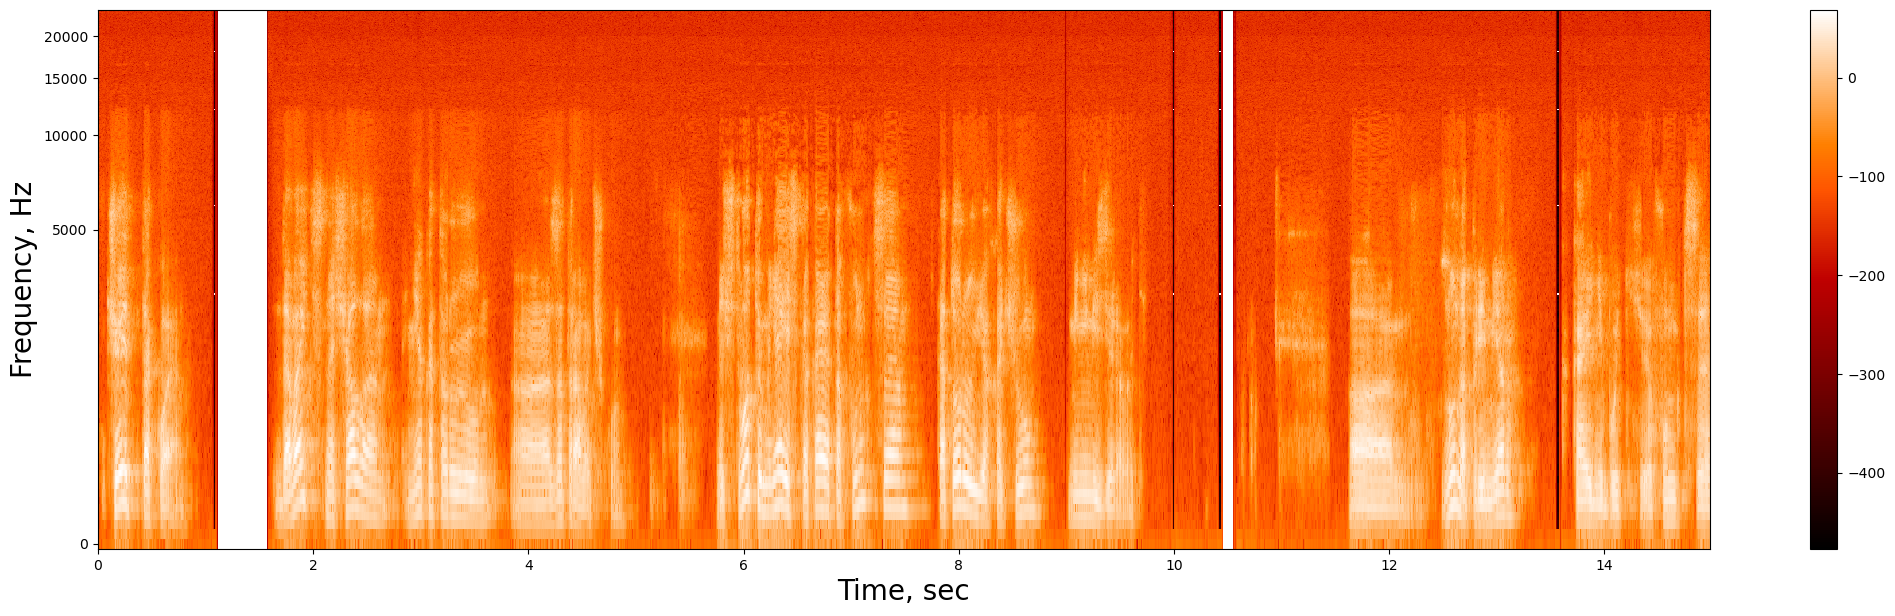

In [141]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

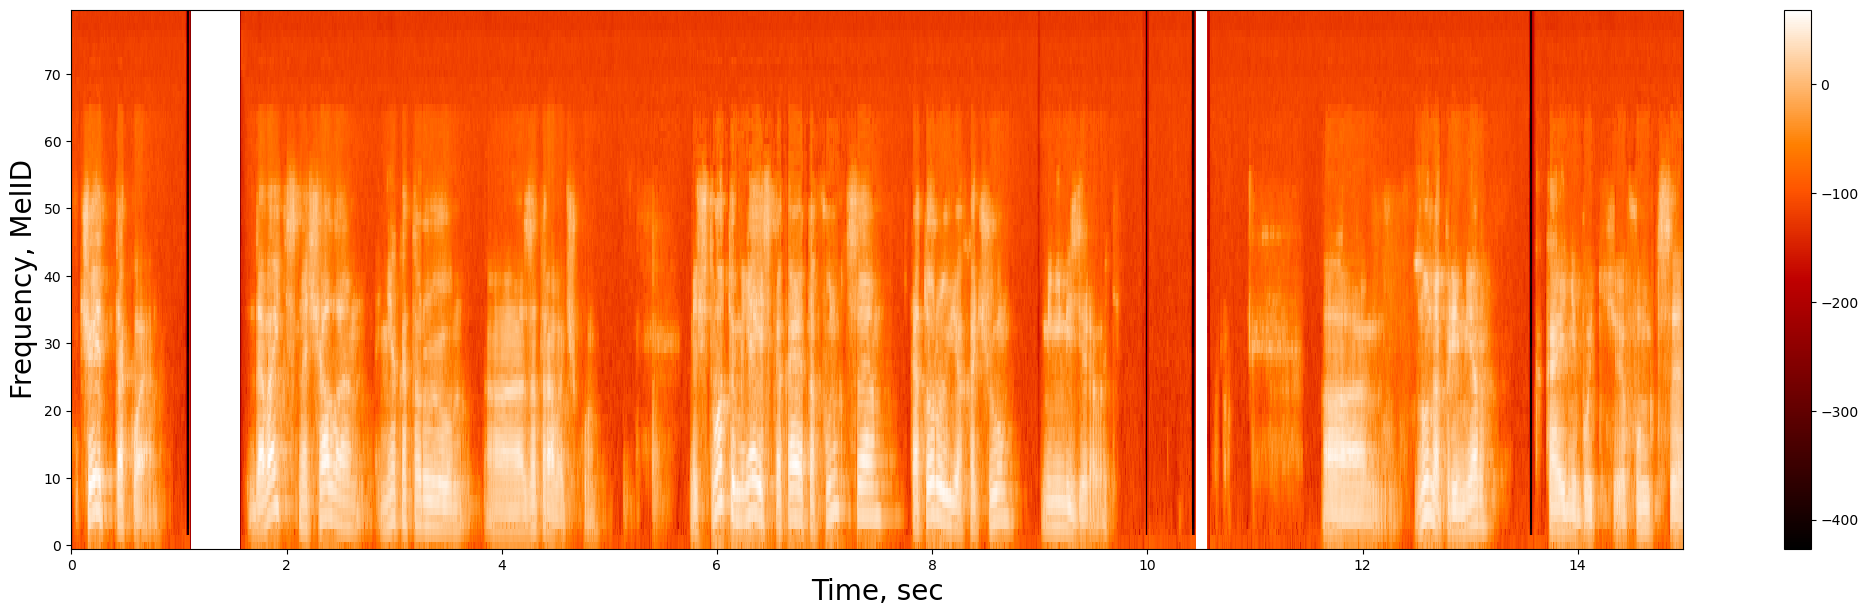

In [143]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,specMel.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(nMels)
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff, 20*torch.log10(specMel.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, MelID', size=20)
f.colorbar(im)
plt.show()

На спектрограмме видим белые промежутки, попробуем продебажить и понять, почему так получилось

In [172]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050, monoConvert: bool = False):
    """Plots the given waveform

    Args:
        wav (torch.Tensor): waveform (Nch, T) or (T,)
        sr (int, optional): sample rate. Defaults to 22050.
    """    
    if(monoConvert):
        # Average all channels
        if(len(wav.shape)>1):
            # Any to mono audio convertion
            wav = wav.mean(dim=0,keepdim=True)
        
        _,ax = plt.subplots(figsize=(14, 4))
        ax.plot(np.arange(0,wav.shape[1]/sr,1/sr),wav, alpha=.7, c='green')
        ax.grid()
        ax.set_xlabel('Time, sec', size=20)
        ax.set_ylabel('Amplitude', size=20)
    else:
        nChannels = wav.shape[0]
        if(nChannels==1):
            _,ax = plt.subplots(figsize=(14, 4))
            ax.plot(np.arange(0,wav.shape[1]/sr,1/sr),wav[0,:], alpha=.7, c='green')
            ax.grid()
            ax.set_xlabel('Time, sec', size=20)
            ax.set_ylabel('Amplitude', size=20)
        else:
            _, axs = plt.subplots(nChannels,1,figsize=(14, 4*nChannels))
            for id,ax in enumerate(axs):
                ax.plot(np.arange(0,wav.shape[1]/sr,1/sr),wav[id,:], alpha=.7, c='green')
                ax.grid()
                ax.set_xlabel('Time, sec', size=20)
                ax.set_ylabel(f'Amplitude, Ch={id+1}', size=20)
        
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

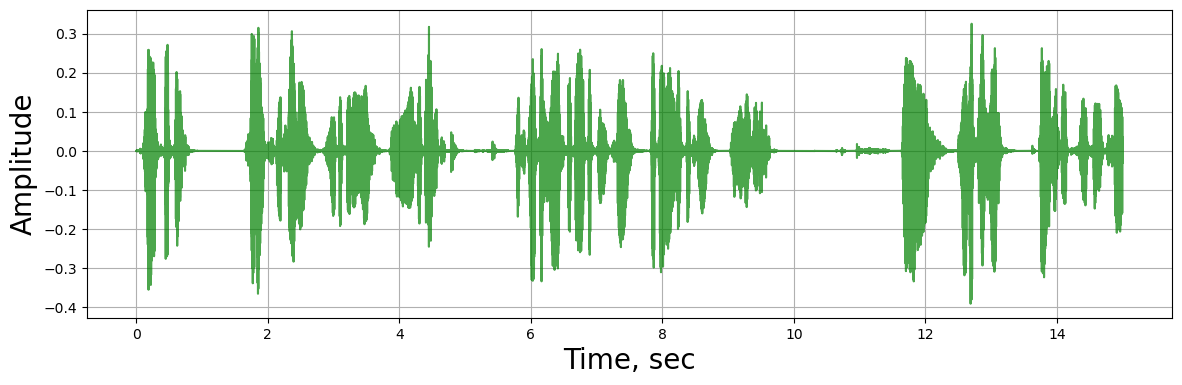

In [173]:
visualize_audio(segment, sr)

In [188]:
segment[:, sr:2*sr-sr//4].squeeze(0)[:100]

tensor([ 3.0518e-05,  3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  3.0518e-05,  3.0518e-05,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.0518e-05, -3.0518e-05,  0.0000e+00,  3.0518e-05,
         3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  3.0518e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0518e-05,
         0.0000e+00,  3.0518e-05,  0.0000e+00, -3.0518e-05, -3.0518e-05,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0518e-05,
         0.0000e+00,  3.0518e-05,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -3.0518e-05,  0.0000e+00,  3.0518e-05,  3.0518e-05,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.0518e-05,
         0.0000e+00,  3.0518e-05,  0.0000e+00,  0.0

<Axes: ylabel='Count'>

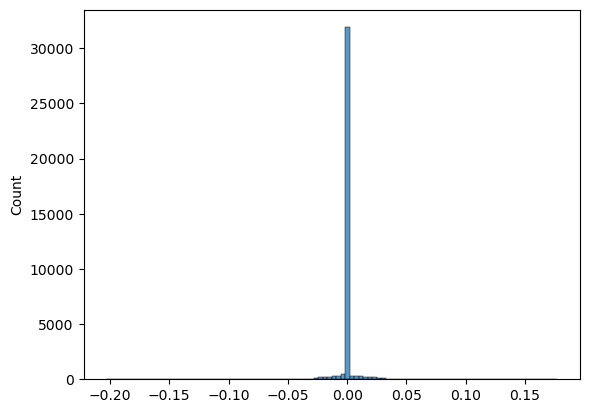

In [221]:
import seaborn as sns
sns.histplot(segment[:, sr:2*sr-sr//4].squeeze(0), bins=100)

=> видимо, yt-dlp так обрабатывает тишину

Cделаем спектрограмму для 2х секунд

In [249]:
segment_2_sec = segment[:, 8*sr:10*sr]
torchaudio.save('2_sec.wav', segment_2_sec, sample_rate=sr)
segment_2_sec, sr = torchaudio.load('2_sec.wav') # оставил для воспроизведения результатов только

In [257]:
specMel_2_sec = melspecTransform(segment_2_sec)
spec_2_sec = specTransform(segment_2_sec)


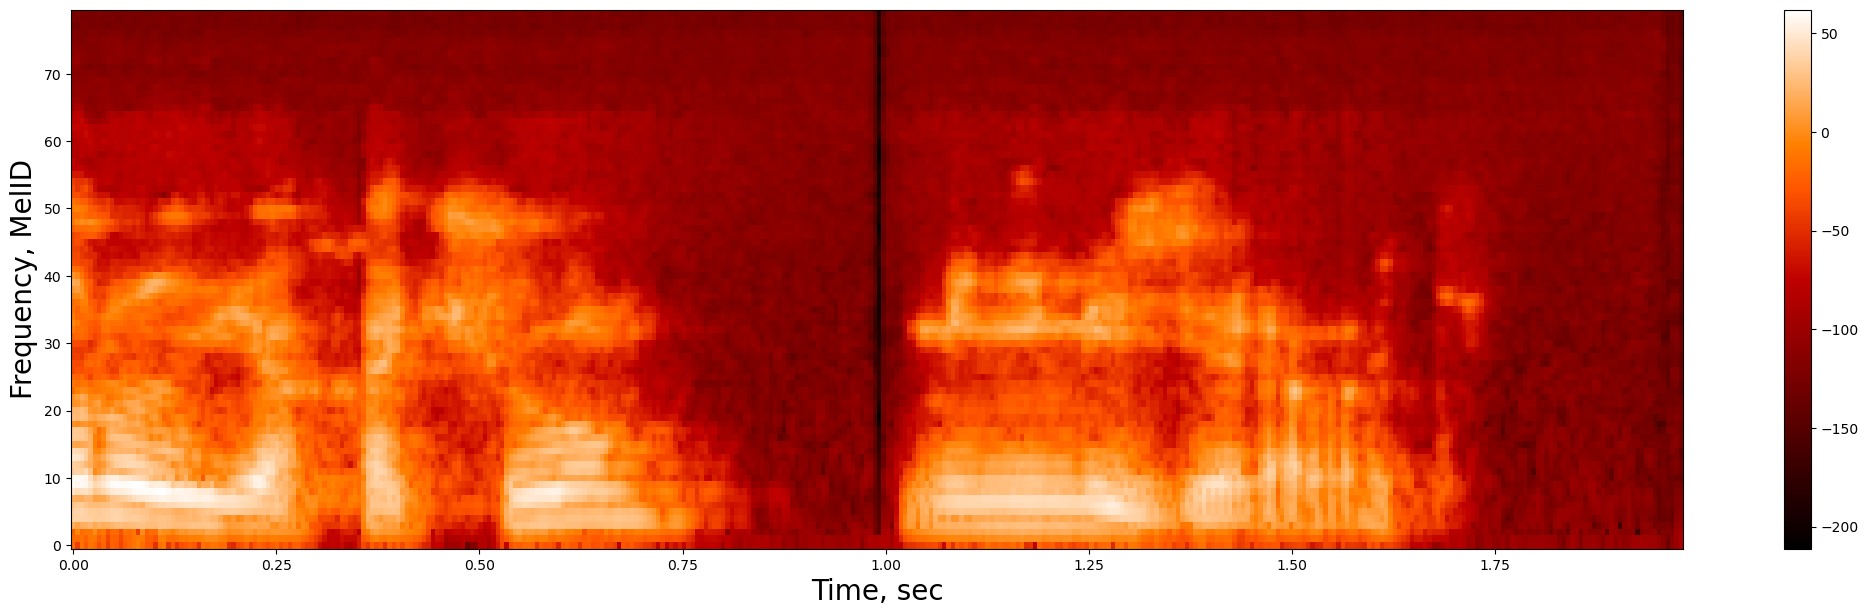

In [258]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,specMel_2_sec.shape[2]*hopSize, hopSize)/sr
fGrid = np.arange(nMels)
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff, 20*torch.log10(specMel_2_sec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, MelID', size=20)
f.colorbar(im)
plt.show()

/var/folders/k8/lnn01fy54g10_kxzrblpjmpw0000gn/T/ipykernel_7744/3604865160.py:2: RuntimeWarning: invalid value encountered in log10
  return 2595*np.log10(1 + f/700) #wikipedia suggestion


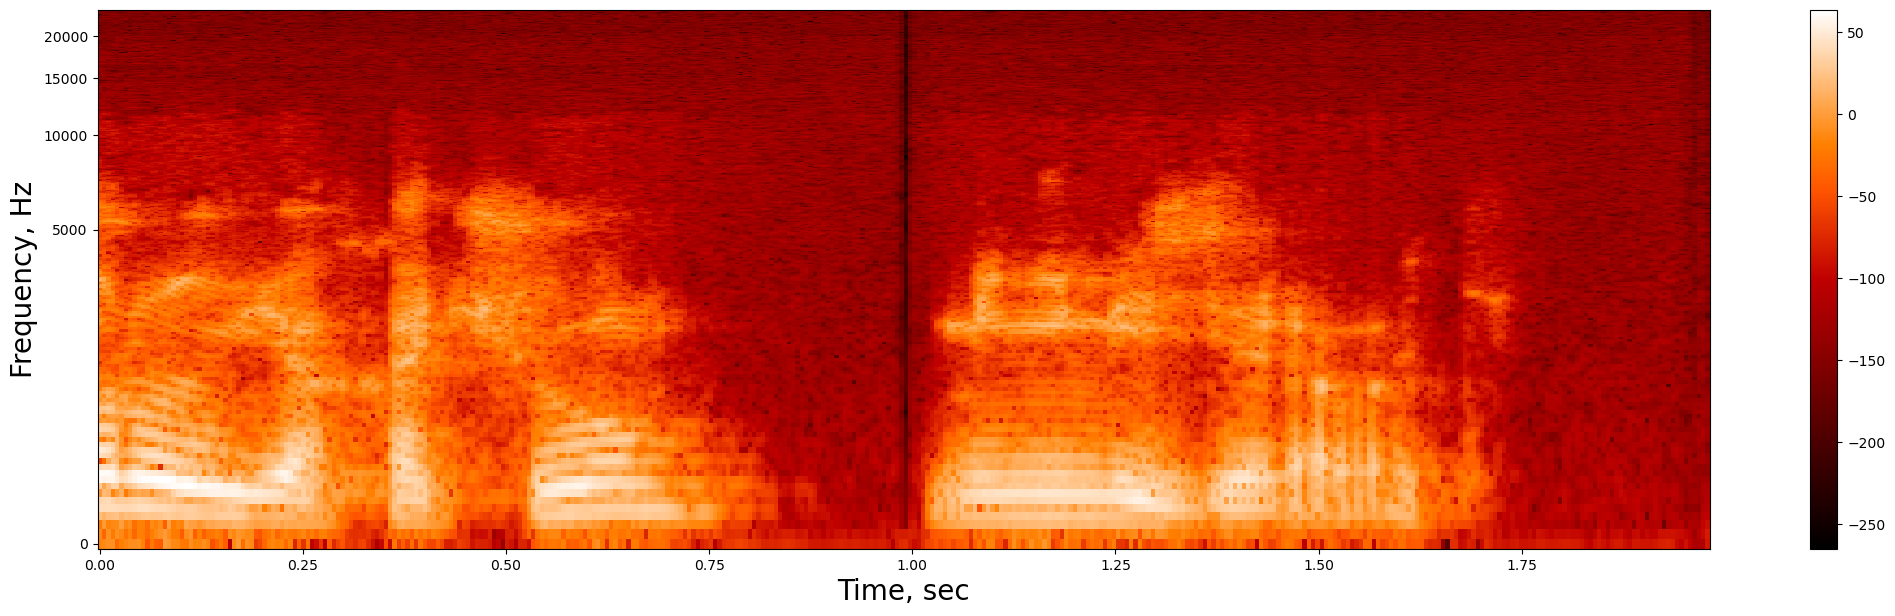

In [259]:
f,ax = plt.subplots(figsize=(26, 7))

tGrid = np.arange(0,spec_2_sec.shape[2]*hopSize, hopSize)/sr
fGrid = freqsR
tt,ff = np.meshgrid(tGrid,fGrid)

im=ax.pcolormesh(tt,ff,20*torch.log10(spec_2_sec.squeeze()),cmap="gist_heat")
ax.set_xlabel('Time, sec', size=20)
ax.set_ylabel('Frequency, Hz', size=20)
ax.set_yscale("function",functions=(melForward,melInverse))
f.colorbar(im)
plt.show()

=> Точно можно попробовать делать очистку от шума